Федоров Антон Сергеевич

группа: М8О-407Б-19

# Лабораторная работа №4

In [12]:
# License: BSD
# Author: Sasank Chilamkurthy

# импортирование необходимых модулей
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True 

cudnn.benchmark = True
# включить интерактивный режим
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

# наборы преобразований изображений для аугментации обучающих и валидационных данных 
data_transforms = {
    # составление нескольких операций преобразования вместе 
    'train': transforms.Compose([
        # вырезание случайной области изображения м преобразованием к размеру 224 на 224
        transforms.RandomResizedCrop(224),
        # случайное горизонтальное переворачивание картинки
        transforms.RandomHorizontalFlip(),
        # преобразование PIL.Image к тензору
        transforms.ToTensor(),
        # нормализация значений пикселей
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # составление нескольких операций преобразования вместе 
    'val': transforms.Compose([
        # преобразование изображения к размеру 256 на 256
        transforms.Resize(256),
        # вырезание центрально области изображения размером 224 на 224
        transforms.CenterCrop(224),
        # преобразование PIL.Image к тензору
        transforms.ToTensor(),
        # нормализация значений пикселей
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# данная функция добавлена из-за специфики датасета
# так как изображения могут иметь програчные пиксели, все они приводятся к формату RGB 
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f).convert('RGBA')
        return img.convert('RGB')

# путь до папки с датасетом
data_dir = 'data/Car-Bike-Dataset'
# датасеты для обучения и валидации
general_image_dataset1 = datasets.ImageFolder(data_dir)
general_image_dataset2 = datasets.ImageFolder(data_dir)

# разбиение датасета на поднаборы для обучения и валидации
train_dataset, _ = torch.utils.data.random_split(general_image_dataset1, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
_, val_dataset = torch.utils.data.random_split(general_image_dataset2, [0.7, 0.3], generator=torch.Generator().manual_seed(42))

# так как после поерации random_split некоторые важные поля у поднаборов отсутствуют, 
# присвою их явно, чтобы не изменять код из официального руководства
train_dataset.classes = general_image_dataset1.classes.copy()
train_dataset.dataset.transform = data_transforms['train']
train_dataset.dataset.loader = pil_loader

val_dataset.classes = general_image_dataset2.classes.copy()
val_dataset.dataset.transform = data_transforms['val']
val_dataset.dataset.loader = pil_loader

# объявление набора датасетов
image_datasets = {'train': train_dataset,
                  'val': val_dataset}
# объявление набора загрузчиков данных
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
# размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# имена классов в датасетах
class_names = image_datasets['train'].classes

# определение используемого железа, если доступна видеокарта с поддержкой CUDA, то используется она, если нет, то используется CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

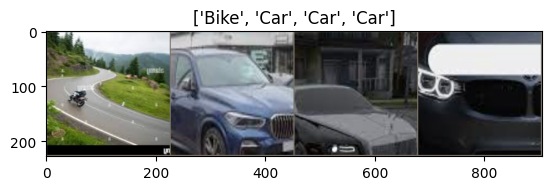

In [3]:
# функция для отрисовки изображения
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # перестановка порядка индексов для корректной работы plt.imshow
    inp = inp.numpy().transpose((1, 2, 0))
    # средние значения и стандартные отклонения
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # обратное преобразование нормализованных данных в пригодный для визуализации вид
    inp = std * inp + mean
    # отсечение значений пикселей больше единицы и меньше нуля
    inp = np.clip(inp, 0, 1)
    # отрисовать изображение
    plt.imshow(inp)
    if title is not None:
        # установить заголовок изображения
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# отрисовать данные
imshow(out, title=[class_names[x] for x in classes])

In [4]:
# функция для обучения модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # начало отсчета времени
    since = time.time()

    # переменная для хранения весов, при которых модель показала себя лучше всего
    best_model_wts = copy.deepcopy(model.state_dict())
    # переменнаЯ для хранения лучшей точности
    best_acc = 0.0

    # цикл по эпохам 
    for epoch in range(num_epochs):
        # печать информации о текущей эпохе
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # установление режима обучения или нет, в зависимости от фазы
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # суммарное значение функции потерь по батчам, умноженное на число элементов в каждом
            running_loss = 0.0
            # число правильных ответов
            running_corrects = 0

            # Iterate over data.
            # проход по батчам
            for inputs, labels in dataloaders[phase]:
                # переместить входные данные и ответы в память требуемого железа
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                # в контексте того, что градиенты для параметров вычисляются
                with torch.set_grad_enabled(phase == 'train'):
                    # получить ответы модели
                    outputs = model(inputs)
                    # получить индексы максимальных значений ответов модели
                    _, preds = torch.max(outputs, 1)
                    # вычислить функцию потерь, исходя из результатов
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # осуществить обратный проход функции ошибки и вычислить градиенты для параметров
                        loss.backward()
                        # оптимизировать параметры
                        optimizer.step()

                # statistics
                # обновить суммарное значение функции потерь
                running_loss += loss.item() * inputs.size(0)
                # обновить число правильных ответов
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                # обновить значение learning rate согласно планировщику
                scheduler.step()

            # вычисление значения функции потерь на эпохе
            epoch_loss = running_loss / dataset_sizes[phase]
            # вычисление точности предсказаний на эпохе
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            # если модель показала облее хорошую точность, чем ее предшественники
            if phase == 'val' and epoch_acc > best_acc:
                # обновить значение лучшей точности
                best_acc = epoch_acc
                # сохранить текущие веса модели как лучшие
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # печать времени, затраченного на обучение
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # загрузка лучших весов модели и ее возвращение
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# функция для визуализации модели
def visualize_model(model, num_images=6):
    # обучалась ли модель
    was_training = model.training
    # перевести модель в необучаемый режим
    model.eval()
    # текущее число изображений
    images_so_far = 0
    fig = plt.figure()

    # в контексте того, что вычислять градиенты модели не требуется
    with torch.no_grad():
        # проходясь по батчам валидационного загрузчика данных
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # переместить входные изображения и ответы в память соответствующего железа
            inputs = inputs.to(device)
            labels = labels.to(device)

            # получить предсказания модели 
            outputs = model(inputs)
            # получить индексы максимальных значений из предсказаний
            _, preds = torch.max(outputs, 1)

            # проходясь по изображениям из батча
            for j in range(inputs.size()[0]):
                # обновить текущее число изображений
                images_so_far += 1

                # извлечение области фигуры для текущего изображения 
                ax = plt.subplot(num_images//2, 2, images_so_far)
                # отключить обозначение осей
                ax.axis('off')
                # установить заголовок
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                # отрисовать изображение, предварительно перенести его в оперативную память CPU
                imshow(inputs.cpu().data[j])

                # если текущее число изображений достигло требуемого
                if images_so_far == num_images:
                    # перевести модель в режим обучения
                    model.train(mode=was_training)
                    return
        # перевести модель в режим обучения                
        model.train(mode=was_training)

In [6]:
# использовать предобученную модель ResNet18
model_ft = models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
# число входных параметров в полносвязанный слой
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# заменить полносвязанный слой на свой, число классов на выходе: 2
model_ft.fc = nn.Linear(num_ftrs, 2)

# переместить модель в память соотвествующего железа
model_ft = model_ft.to(device)

# использовать кросс-энтропию, как функцию ошибки
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# обучать модель стохастическим градиентным спуском с моментом
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# использовать планировщик learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
# обучить модель
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4436 Acc: 0.8389
val Loss: 0.0391 Acc: 0.9850

Epoch 1/24
----------
train Loss: 0.3849 Acc: 0.8689
val Loss: 0.0405 Acc: 0.9833

Epoch 2/24
----------
train Loss: 0.3564 Acc: 0.8725
val Loss: 0.0473 Acc: 0.9825

Epoch 3/24
----------
train Loss: 0.3283 Acc: 0.8864
val Loss: 0.0570 Acc: 0.9808

Epoch 4/24
----------
train Loss: 0.2701 Acc: 0.9021
val Loss: 0.0477 Acc: 0.9892

Epoch 5/24
----------
train Loss: 0.2406 Acc: 0.9111
val Loss: 0.0398 Acc: 0.9892

Epoch 6/24
----------
train Loss: 0.1713 Acc: 0.9339
val Loss: 0.0324 Acc: 0.9917

Epoch 7/24
----------
train Loss: 0.1054 Acc: 0.9618
val Loss: 0.0304 Acc: 0.9925

Epoch 8/24
----------
train Loss: 0.0958 Acc: 0.9650
val Loss: 0.0279 Acc: 0.9925

Epoch 9/24
----------
train Loss: 0.1000 Acc: 0.9596
val Loss: 0.0272 Acc: 0.9925

Epoch 10/24
----------
train Loss: 0.0953 Acc: 0.9682
val Loss: 0.0275 Acc: 0.9933

Epoch 11/24
----------
train Loss: 0.0831 Acc: 0.9714
val Loss: 0.0283 Acc: 0.9933

Ep

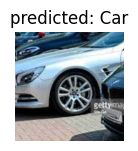

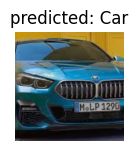

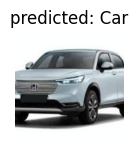

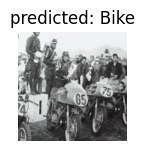

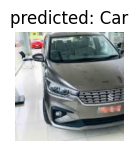

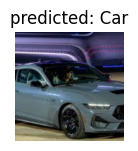

In [8]:
# визуализировать модель 
visualize_model(model_ft)

In [9]:
# использовать преобученную модель ResNet18
model_conv = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
# отключить вычисление градиентов для всех параметров модели
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# число входных параметров в полносвязанный слой
num_ftrs = model_conv.fc.in_features
# заменить полносвязанный слой на новый, который бцдет обучаться
model_conv.fc = nn.Linear(num_ftrs, 2)

# переместить модель в память соответствующего железа
model_conv = model_conv.to(device)

# использовать кросс-энтропию, как функцию ошибки
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# использовать стохастический градиентный спуск с моментом для обучения
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# использовать планировщик learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
# обучить модель
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4215 Acc: 0.8250
val Loss: 0.2047 Acc: 0.9242

Epoch 1/24
----------
train Loss: 0.4086 Acc: 0.8543
val Loss: 0.0536 Acc: 0.9792

Epoch 2/24
----------
train Loss: 0.4195 Acc: 0.8500
val Loss: 0.3112 Acc: 0.8992

Epoch 3/24
----------
train Loss: 0.3911 Acc: 0.8604
val Loss: 0.0754 Acc: 0.9775

Epoch 4/24
----------
train Loss: 0.3595 Acc: 0.8604
val Loss: 0.0766 Acc: 0.9700

Epoch 5/24
----------
train Loss: 0.3853 Acc: 0.8604
val Loss: 0.0704 Acc: 0.9742

Epoch 6/24
----------
train Loss: 0.3818 Acc: 0.8632
val Loss: 0.0485 Acc: 0.9817

Epoch 7/24
----------
train Loss: 0.2980 Acc: 0.8832
val Loss: 0.0371 Acc: 0.9867

Epoch 8/24
----------
train Loss: 0.2683 Acc: 0.8943
val Loss: 0.0370 Acc: 0.9858

Epoch 9/24
----------
train Loss: 0.2792 Acc: 0.8771
val Loss: 0.0384 Acc: 0.9858

Epoch 10/24
----------
train Loss: 0.2997 Acc: 0.8804
val Loss: 0.0353 Acc: 0.9867

Epoch 11/24
----------
train Loss: 0.2825 Acc: 0.8804
val Loss: 0.0360 Acc: 0.9892

Ep

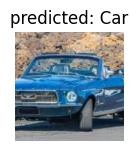

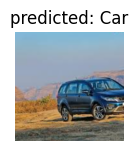

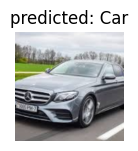

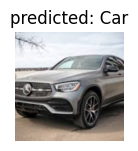

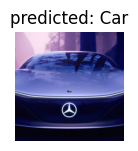

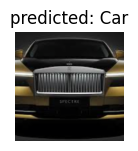

In [11]:
# визуализировать модель
visualize_model(model_conv)

# отключить интерактивный режим
plt.ioff()
# отрисовать
plt.show()